# Import the libraries used

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf


# plt.style.use('dark_background')

In [ ]:
!git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git

In [2]:
# data_path = Path('/content/drive/MyDrive/SUPSI/Sixth semester/Time Series/Final Project D3A - Ippolito, Loddo, Margni/data/')
data_path = Path('Data/')
data_path

WindowsPath('Data')

# Import the data

In [3]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533
2020-01-01 00:45:00+00:00,965.320000,5.639200,-2.406067,0.0,49.093333,0.923733
2020-01-01 01:00:00+00:00,965.300000,6.030800,-2.363267,0.0,47.546667,0.916733


In [4]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [5]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
df_nwp.head()

ghi_backwards                                        \
                                    0       1       10     100  101  102  103   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0  0.0   
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0  0.0   

                                                  ... temperature              \
                             104     105     106  ...         90    91    92    
2020-01-01 00:00:00+00:00  26.58  127.41  234.86  ...        5.27  4.30  3.57   
2020-01-01 12:00:00+00:00   0.00    0.00    0.00  ...        0.44  1.49  2.98   
2020-01-02 00:00:00+00:00  25.69  124.16  229.88  ...        3.81  2.69  1.60   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00  ...        0.83  1.70  2.81   
2020-01-03 00:00:00+00:00  25.68  121.78  221.89  ...        2.87  2.05  1.34   

                                                                     
                            93    94    95    96    97    98    99   
2020-01-01 00:00:00+00:00  3.00  2.57  2.21  1.88  1.59  1.32  1.08  
2020-01-01 12:00:00+00:00  4.72  6.54  8.30  9.51  9.81  9.15  7.88  
2020-01-02 00:00:00+00:00  0.62 -0.21 -0.31 -0.11  0.37  0.50  0.67  
2020-01-02 12:00:00+00:00  4.09  5.42  6.75  7.58  7.72  7.12  6.15  
2020-01-03 00:00:00+00:00  0.72  0.24 -0.08 -0.26 -0.26 -0.15  0.06  

[5 rows x 507 columns]

Check columns of the 3 datasets

In [6]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [7]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [8]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

Get rid of MultiIndex in df_meters and df_nwp

In [9]:
# Get rid of the MultiIndex in df_meters
# df_meters.columns = df_meters.columns.droplevel(0)
# df_meters.columns

In [10]:
# Get rid of the MultiIndex in df_nwp
# df_nwp.columns = df_nwp.columns.droplevel(1)
# df_nwp.columns

# Exploratory Data Analysis

Visualize the data in df_meteo

<Axes: >

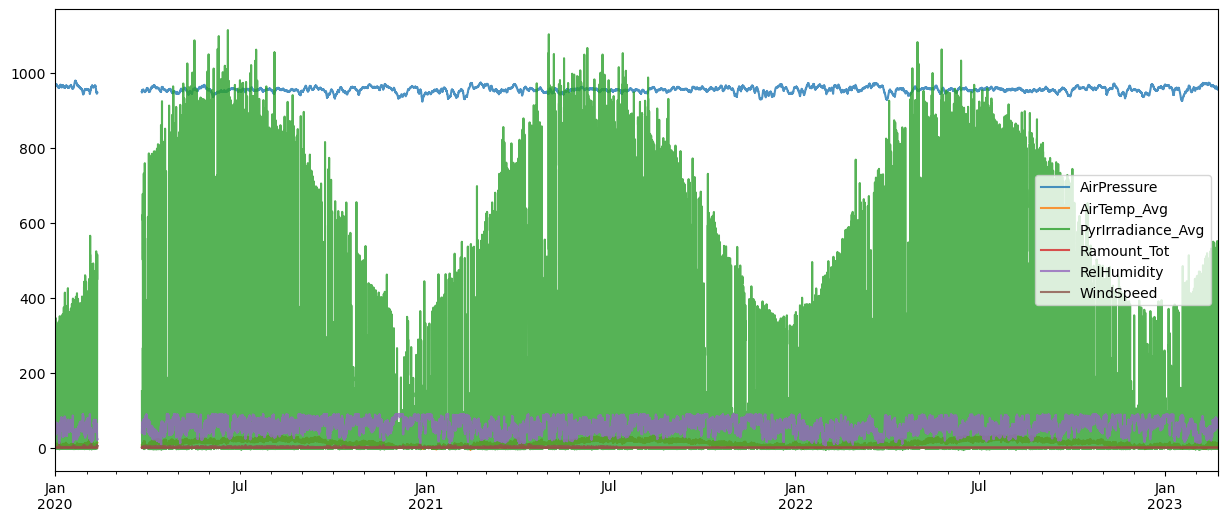

In [11]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

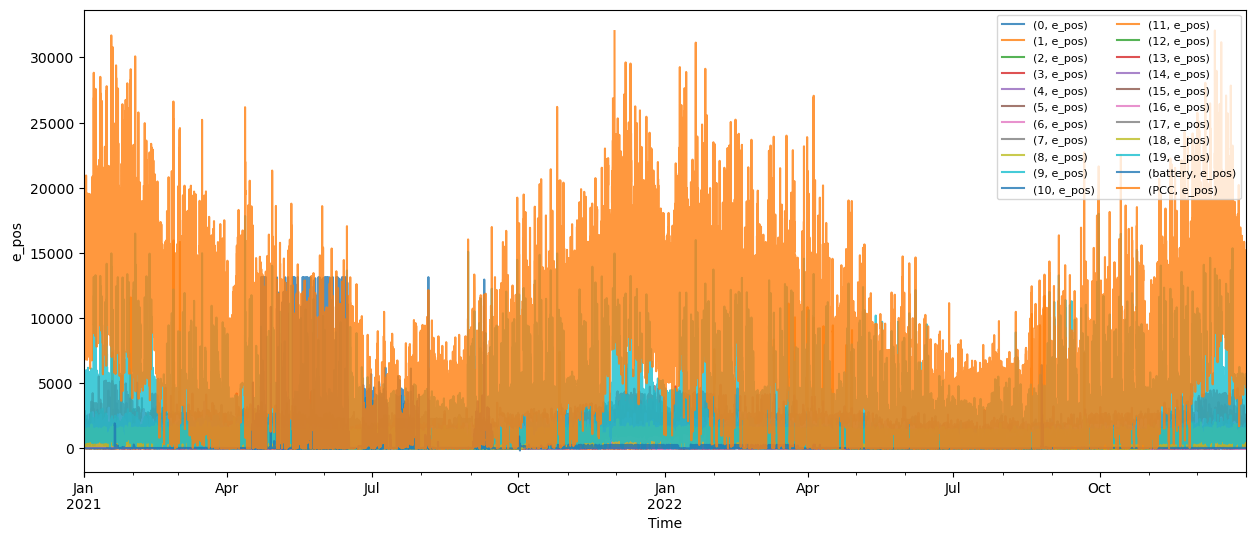

In [12]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

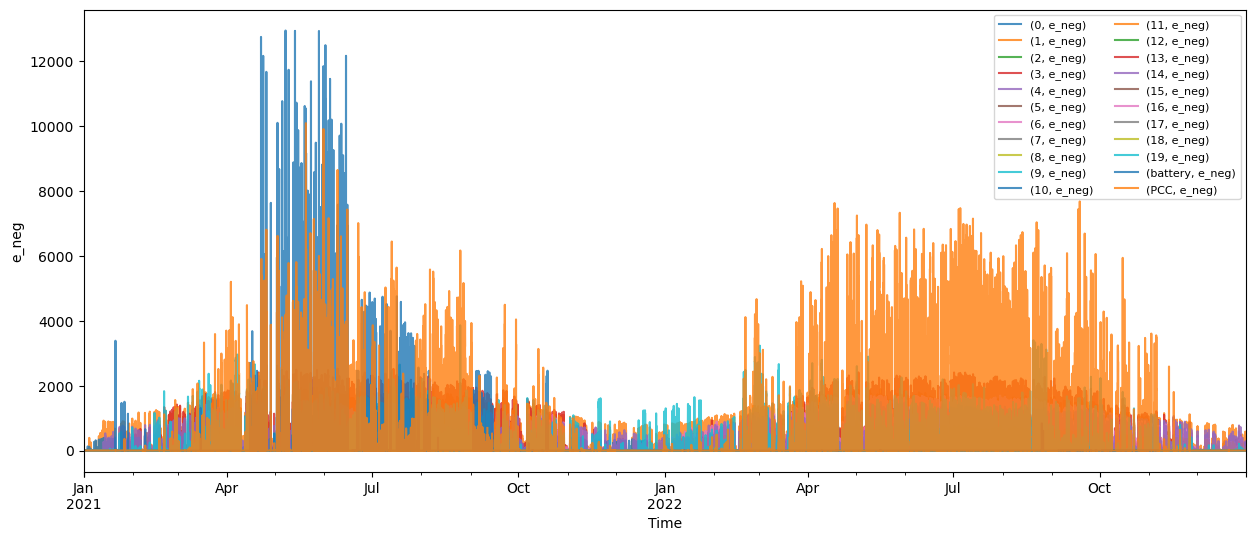

In [16]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

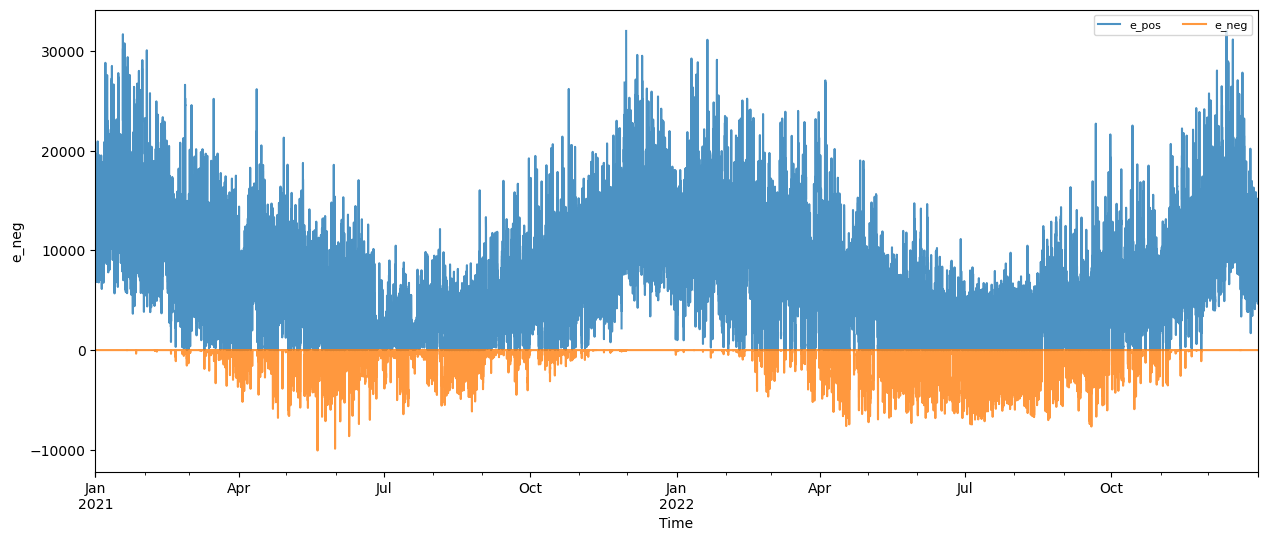

In [22]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]
# Plot the e_neg columns against the DataFrame's index
df["PCC"].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [36]:
# df_meters.info()

# df_meters['bho'] = df_meters.iloc[:, 7].copy()

# df_meters[(1, 'e_pos')]

df_meters.isna().sum()



0        e_pos      4
         e_neg      4
1        e_pos      5
         e_neg      5
2        e_pos      6
         e_neg      6
3        e_pos      5
         e_neg      5
4        e_pos      8
         e_neg      8
5        e_pos      1
         e_neg      1
6        e_pos      1
         e_neg      1
7        e_pos      1
         e_neg      1
8        e_pos      4
         e_neg      4
9        e_pos      8
         e_neg      8
10       e_pos      2
         e_neg      2
11       e_pos     15
         e_neg     15
12       e_pos      2
         e_neg      2
13       e_pos      1
         e_neg      1
14       e_pos      0
         e_neg      0
15       e_pos      1
         e_neg      1
16       e_pos      4
         e_neg      4
17       e_pos      4
         e_neg      4
18       e_pos    284
         e_neg    284
19       e_pos      1
         e_neg      1
battery  e_pos     41
         e_neg     41
PCC      e_pos    234
         e_neg    239
bho                 5
dtype: int

Visualize the data in df_nwp

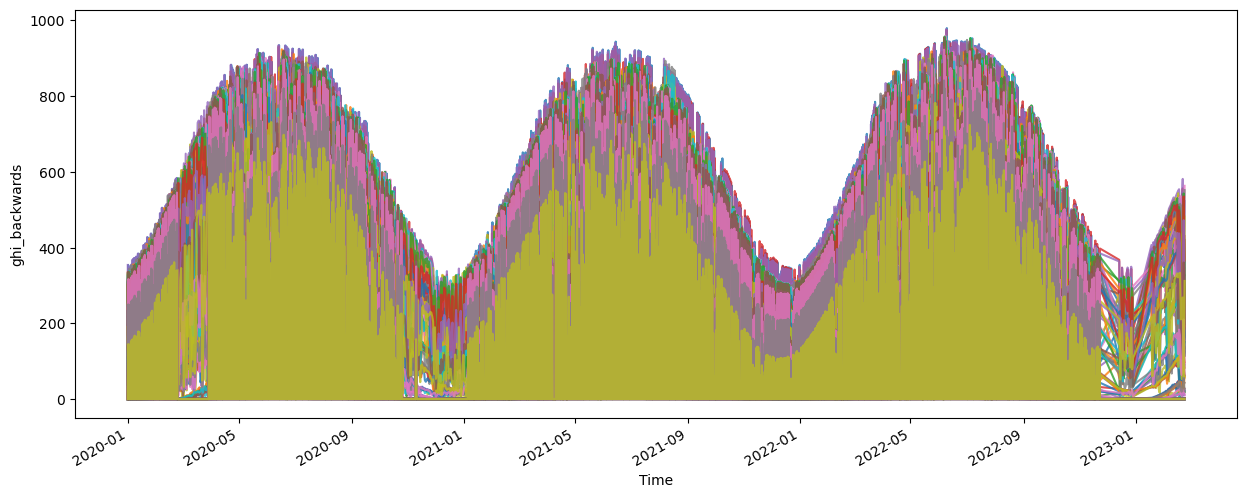

In [14]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

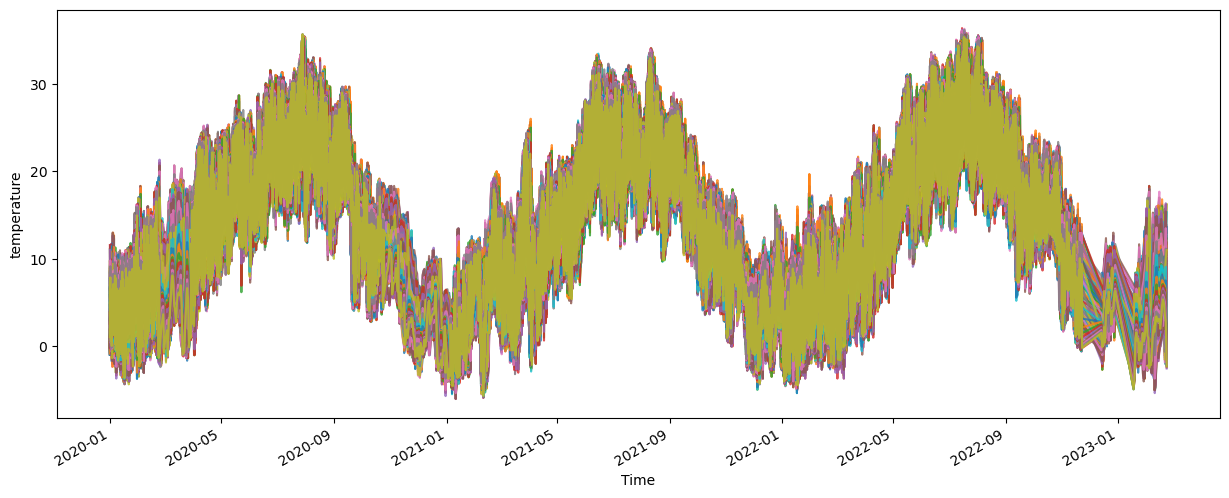

In [15]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

Comments on the data after having explored it

ValueError: x is required to have ndim 1 but has ndim 2

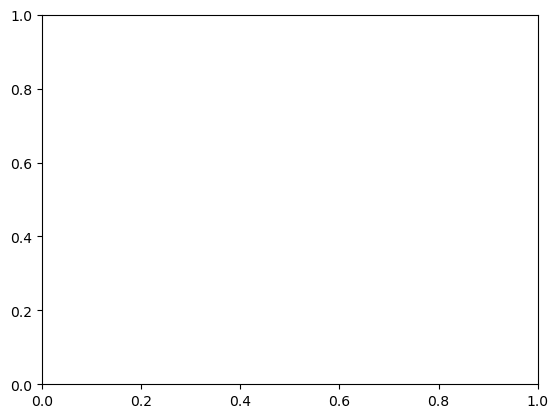

In [35]:
plot_acf(df_meters, lags=24*7)

# Clean and Scale data (if needed)

# Feature Selection

# Models building

# Model selection